# 学習開始
---
### 利用バージョン
python 2 (python 3にしたかったけど、色々環境設定しないといけなさそうなので・・)

## 概要
ここでは、
* GPUの使用有無、バッチサイズ、繰り返し回数を指定します。
* 実際にAIに学習させます。
* 学習ログ確認
* 繰り返し学習をするための.pyファイル作成

といった事をします。

## 変数定義
* GPUを使う場合は0を、使わない場合は-1をgpu_id設定します。
* パラメータ更新する頻度(多分・・・）をbatchsizeに指定します。
* 何回繰り返して終了するかをmax_epochに指定します。

In [1]:
gpu_id = 0
unit_size = 200
batchsize = 500
max_epoch = 50

## 学習スタート
私も中途半端な理解ではありますが、ここからはちょっと細かく説明します。

### 出力フォルダのファイル削除
まずはchainerの各種ファイルの出力先のフォルダ(result)配下にあるファイルを全部削除します。

In [2]:
import os

# 出力フォルダ配下のファイル全削除の関数
def remove_dir_and_file(top):
    for root, dirs, files in os.walk(top, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            os.rmdir(os.path.join(root, name))

remove_dir_and_file(u'result')

### 画像ファイルのパスと教師データ一覧読み込み
次に、画像ファイル名(パス付き)と好き(1) or 嫌い(0)の教師データ一覧情報を読み込みます。

In [3]:
image_files = os.path.join(u'dataset', u'03_duplicate_pict_anser.csv') # 画像ファイル名と教師データの一覧ファイルのパス
import pandas as pd
df = pd.read_csv(image_files, names=[u'pictFileName', 'anser'], sep=' ') #　スペース区切り
df.head()

,pictFileName,anser
0,dataset/03_duplicatePict/1_56_19.jpg,1
1,dataset/03_duplicatePict/1_42_3.jpg,1
2,dataset/03_duplicatePict/1_25_19.png,1
3,dataset/03_duplicatePict/1_26_6.jpg,1
4,dataset/03_duplicatePict/1_28_5.jpg,1


画像ファイルの数を数えます。

In [4]:
len(df)

2400

### データセットの準備
datasets.LabeledImageDataset(先ほどのcsvのパス)を実行すると、chainerが扱いやすい形に画像データと教師データを読み込んでくれます

In [5]:
from chainer import datasets
dataset = datasets.LabeledImageDataset(image_files)
dataset

データセットがどんなデータか確認します。まずはdatasetの件数を確認します。

In [6]:
len(dataset)

2400

datasetの件数=画像ファイル数ということがわかりました。では、[0]を入れて1レコード目のデータを抽出してみます。

In [7]:
dataset[0]

(array([[[ 17.,  19.,  31., ...,  36.,  35.,  28.],
         [ 20.,  21.,  33., ...,  37.,  34.,  27.],
         [ 23.,  26.,  39., ...,  37.,  35.,  26.],
         ...,
         [113., 110., 108., ..., 102., 102., 101.],
         [123., 120., 117., ..., 109., 101., 100.],
         [124., 120., 119., ..., 109., 101., 100.]],
 
        [[ 39.,  38.,  49., ...,  52.,  56.,  51.],
         [ 38.,  38.,  48., ...,  53.,  55.,  50.],
         [ 33.,  36.,  46., ...,  52.,  54.,  49.],
         ...,
         [170., 167., 164., ..., 163., 163., 161.],
         [180., 176., 173., ..., 170., 162., 161.],
         [180., 176., 172., ..., 170., 162., 161.]],
 
        [[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   9., ...,   0.,   0.,   0.],
         [  8.,  12.,  28., ...,   0.,   0.,   0.],
         ...,
         [  5.,   0.,   0., ...,   0.,   0.,   1.],
         [ 13.,   7.,   2., ...,   5.,   0.,   0.],
         [ 11.,   7.,   2., ...,   5.,   0.,   0.]]], dtype=float32)

In [8]:
type(dataset[0])

tuple

画像データと教師データのタプル型だということが分かりました。次にdataset[0][0].shapeで画像データのサイズを見てみます。

In [9]:
dataset[0][0].shape

(3, 250, 250)

(color(r,g,b), x, y)形式で保持していることが分かりました。なお、[ここ](http://www.kumilog.net/entry/chainer-dataset)とかによると

>シンプルなデータセット
>基本的には、len()で要素数を取得できたり、[1:2]のようにスライスで要素を取得できれば、データセットとして扱うことができます。
>
>ということで、最もシンプルなデータセットはNumpyの配列です。

> *dataset = numpy.array([1, 2, 3], dtype=numpy.float32)* 

とのことです。

また、入力するデータはfloat32(今回は画像データ)、教師データはint32にする必要があります。


### データセットの加工
RGBの画素値はそれぞれ0〜255をとります。一方、Chainerに入れるデータは0〜1のfloat型にする必要があります。したがって255で割ることで0〜1に変換します。簡単あ変換であればchainer.datasets.TransformDataset(<データセット>, <変換する内容を書いた関数>)で変換できます。

データセットは、(画像データ, 教師データ)のタプル型で保持しているため、img, label = dataで両者を分割し、imgを255で割った結果とlabelを返す関数transformを定義します。

In [10]:
import chainer

def transform(data):
    img, lable = data
    img = img / 255.
    return img, lable

# データ部を0〜1の値にする必要があるため255で割ります
dataset = chainer.datasets.TransformDataset(dataset, transform)

変換したデータセットの中身をサンプルで確認します。

In [11]:
dataset[0]

(array([[[0.06666667, 0.07450981, 0.12156863, ..., 0.14117648,
          0.13725491, 0.10980392],
         [0.07843138, 0.08235294, 0.12941177, ..., 0.14509805,
          0.13333334, 0.10588235],
         [0.09019608, 0.10196079, 0.15294118, ..., 0.14509805,
          0.13725491, 0.10196079],
         ...,
         [0.44313726, 0.43137255, 0.42352942, ..., 0.4       ,
          0.4       , 0.39607844],
         [0.48235294, 0.47058824, 0.45882353, ..., 0.42745098,
          0.39607844, 0.39215687],
         [0.4862745 , 0.47058824, 0.46666667, ..., 0.42745098,
          0.39607844, 0.39215687]],
 
        [[0.15294118, 0.14901961, 0.19215687, ..., 0.20392157,
          0.21960784, 0.2       ],
         [0.14901961, 0.14901961, 0.1882353 , ..., 0.20784314,
          0.21568628, 0.19607843],
         [0.12941177, 0.14117648, 0.18039216, ..., 0.20392157,
          0.21176471, 0.19215687],
         ...,
         [0.6666667 , 0.654902  , 0.6431373 , ..., 0.6392157 ,
          0.6392157 , 0.

### トレーニングデータとテストデータと分割
データセットをトレーニングデータとテストデータに分割し、過学習にならないようにチェックできるようにします。

In [12]:
# 8割を学習データに、2割をテストデータにします。
split_at = int(len(dataset) * 0.8)
train, test = datasets.split_dataset(dataset, split_at)

In [13]:
len(train)

1920

In [14]:
len(test)

480

### イテレータにデータセットを渡す
データセットから決まった数のデータを取り出し、それらを束ねてミニバッチを作成して返してくれるIteratorを作成しましょう。

- Chainerがいくつか用意しているIteratorの一種である`SerialIterator`は、データセットの中のデータを順番に取り出してくる最もシンプルなIteratorです。
- 引数にデータセットオブジェクトと、バッチサイズを取ります。
- また、このとき渡したデータセットから、何周も何周もデータを繰り返し読み出す必要がある場合は`repeat`引数を`True`とし、1周が終わったらそれ以上データを取り出したくない場合はこれを`False`とします。デフォルトでは、`True`になっています。
- `shuffle`引数に`True`を渡すと、データセットから取り出されてくるデータの順番をエポックごとにランダムに変更します。

ミニバッチとはなんぞや？という方は、[ここ](http://s0sem0y.hatenablog.com/entry/2017/07/08/152859)とかが分かりやすいかも？

In [15]:
from chainer import iterators

train_iter = iterators.SerialIterator(train, batchsize, shuffle=True)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=True)

### トレーニング
class MLPに人工知能のモデルの定義をします。ここでは全結合層(L.Linearが全結合の意味)のみからなる５層のネットワークを定義します。活性化関数はreluを使用します。

model = MLP()で上記モデルをmodelに読み込みます。

L.Classfierは[ここ](https://qiita.com/mitmul/items/eccf4e0a84cb784ba84a)によると、以下のようなイメージだそうです。

>ここで、上で定義したモデルのオブジェクトをL.Classifierに渡して、新しいChainにしています。L.ClassifierはChainを継承したクラスで、渡されたChainをpredictorというプロパティに保存します。()アクセサでデータとラベルを渡すと、中で__call__が実行され、まず渡されたデータの方をpredictorに通し、その出力yと、データと一緒に__call__に渡されていたラベルを、コンストラクタのlossfun引数で指定されたロス関数に渡して、その出力Variableを返します。lossfunはデフォルトでsoftmax_cross_entropyに指定されています

model.to_gpuでGPUを使った学習をすることが可能です。

In [16]:
import chainer.links as L

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=unit_size, n_out=2):
        # パラメータを持つ層の登録
        super(MLP, self).__init__(
            l1=L.Linear(None, n_mid_units),
            l2=L.Linear(None, n_mid_units),
            l3=L.Linear(None, n_mid_units),
            l4=L.Linear(None, n_mid_units),
            l5=L.Linear(None, n_out),
        )

    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        h4 = F.relu(self.l4(h3))
        return self.l5(h4)

# モデルをClassifierで包んで、ロスの計算などをモデルに含める
model = MLP()
model = L.Classifier(model)
model.to_gpu(gpu_id)

### 最適化手法の選択
Chainerのドキュメントから抜粋
>Chainerは多くの最適化手法を提供しています。`chainer.optimizers`モジュール以下にそれらはあります。ここでは最もシンプルな勾配降下法の手法である`optimizers.SGD`を用います。Optimizerのオブジェクトには、`setup`メソッドを使ってモデル（`Chain`オブジェクト）を渡します。こうすることでOptimizerは、自身が更新すべきモデル内のパラメータを自動的にたどってくれます。
>
>他にもいろいろな最適化手法が手軽に試せるので、色々と試してみて結果の変化を見てみてください。例えば、下の`chainer.optimizers.SGD`のうち`SGD`の部分を`MomentumSGD`, `RMSprop`,  `Adam`などに変えて、結果の違いを見てみましょう。

In [17]:
from chainer import optimizers

# 最適化手法の選択
optimizer = optimizers.SGD()
optimizer.setup(model)

### Trainer, Updaterの提議
これもChainerのドキュメントから抜粋

>Trainerは学習に必要な全てのものをひとまとめにするクラスです。それは主に以下のようなものを保持します。
>
>- Updater
>    - Iterator
>        - Dataset
>   - Optimizer
>        - Model
>
>`Trainer`オブジェクトを作成するときに渡すのは基本的に`Updater`だけですが、`Updater`は中に`Iterator`と`Optimizer`を持っています。`Iterator`からはデータセットにアクセスすることができ、`Optimizer`は中でモデルへの参照を保持しているので、モデルのパラメータを更新することができます。つまり、`Updater`が内部で
>
>1. データセットからデータを取り出し（Iterator）
>2. モデルに渡してロスを計算し（Model = Optimizer.target）
>3. Optimizerを使ってモデルのパラメータを更新する（Optimizer）
>
>という一連の学習の主要部分を行うことができるということです。では、`Updater`オブジェクトを作成してみます。

In [18]:
from chainer import training

# UpdaterにIteratorとOptimizerを渡す
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

# TrainerにUpdaterを渡す
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='result')

Trainerについて、Chainerのドキュメントからさらに抜粋
>最後に、Trainerの設定を行います。Trainerのオブジェクトを作成する際に必須となるのは、先程作成したUpdaterオブジェクトだけですが、二番目の引数stop_triggerに学習をどのタイミングで終了するかを表す(長さ, 単位)という形のタプルを与えると、指定したタイミングで学習を自動的に終了することができます。長さには任意の整数、単位には'epoch'か'iteration'のいずれかの文字列を指定できます。stop_triggerを指定しない場合、学習は自動的には止まりません。

### TrainerにExtensionを追加する
これも抜粋

>`Trainer`を使う利点として、
>
>- ログを自動的にファイルに保存（`LogReport`)
>- ターミナルに定期的にロスなどの情報を表示（`PrintReport`）
>- ロスを定期的にグラフで可視化して画像として保存（`PlotReport`)
>- 定期的にモデルやOptimizerの状態を自動シリアライズ（`snapshot`/`snapshot_object`）
>- 学習の進捗を示すプログレスバーを表示（`ProgressBar`）
>- モデルの構造をGraphvizのdot形式で保存（`dump_graph`）
>
>などなどの様々な便利な機能を簡単に利用することができる点があります。これらの機能を利用するには、`Trainer`オブジェクトに対して`extend`メソッドを使って追加したい`Extension`のオブジェクトを渡してやるだけです。では実際に幾つかの`Extension`を追加してみましょう。

In [19]:
from chainer.training import extensions

# ログの出力方法などの定義
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

### `LogReport`

`epoch`や`iteration`ごとの`loss`, `accuracy`などを自動的に集計し、`Trainer`の`out`引数で指定した出力ディレクトリに`log`というファイル名で保存します。

### `snapshot`

`Trainer`の`out`引数で指定した出力ディレクトリに`Trainer`オブジェクトを指定されたタイミング（デフォルトでは1エポックごと）に保存します。`Trainer`オブジェクトは上述のように`Updater`を持っており、この中に`Optimizer`とモデルが保持されているため、この`Extension`でスナップショットをとっておけば、学習の復帰や学習済みモデルを使った推論などが学習終了後にも可能になります。

### `snapshot_object`

しかし、`Trainer`ごと保存した場合、しばしば中身のモデルだけ取り出すのが面倒な場合があります。そこで、`snapshot_object`を使って指定したオブジェクト（ここでは`Classifier`で包まれたモデル）だけを、`Trainer`とは別に保存するようにします。`Classifier`は第1引数に渡された`Chain`オブジェクトを自身の`predictor`というプロパティとして保持してロスの計算を行う`Chain`であり、`Classifier`はそもそもモデル以外にパラメータを持たないので、ここでは後々学習済みモデルを推論に使うことを見越して`model.predictor`を保存対象として指定しています。

### `dump_graph`

指定された`Variable`オブジェクトから辿れる計算グラフをGraphvizのdot形式で保存します。保存先は`Trainer`の`out`引数で指定した出力ディレクトリです。

### `Evaluator`

評価用のデータセットの`Iterator`と、学習に使うモデルのオブジェクトを渡しておくことで、学習中のモデルを指定されたタイミングで評価用データセットを用いて評価します。

### `PrintReport`

`Reporter`によって集計された値を標準出力に出力します。このときどの値を出力するかを、リストの形で与えます。

### `PlotReport`

引数のリストで指定された値の変遷を`matplotlib`ライブラリを使ってグラフに描画し、出力ディレクトリに`file_name`引数で指定されたファイル名で画像として保存します。

---

これらの`Extension`は、ここで紹介した以外にも、例えば`trigger`によって個別に作動するタイミングを指定できるなどのいくつかのオプションを持っており、より柔軟に組み合わせることができます。詳しくは公式のドキュメントを見てください：[Trainer extensions](http://docs.chainer.org/en/latest/reference/extensions.html)。

### 学習を開始する

学習を開始するには、`Trainer`オブジェクトのメソッド`run`を呼ぶだけです。

In [20]:
import chainer.functions as F
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.758072    0.512          0.789683              0.5125                    3.96564       
2           0.891206    0.4785         0.727729              0.5125                    24.0193       
3           0.693856    0.508          0.68371               0.4875                    43.9745       
4           0.680256    0.506          0.678006              0.4875                    58.5985       
5           0.675475    0.564          0.672528              0.666667                  72.9512       
6           0.666822    0.601          0.694879              0.4875                    87.4023       
7           0.68986     0.494          0.684494              0.5125                    101.047       
8           0.665846    0.582          0.659429              0.4875                    129.85        
9           0.736675    0.477          0.686593              0.4875                 

### 学習結果を保存する。


In [26]:
from chainer import serializers

model.to_cpu() # CPUで計算できるようにしておく
serializers.save_npz(os.path.join(u'result', u'sakamotsu.model'), model)

## 学習ログの表示

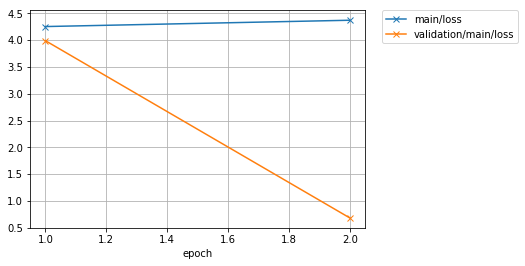

In [23]:
from IPython.display import Image
Image(filename=os.path.join(u'result', u'loss.png'))

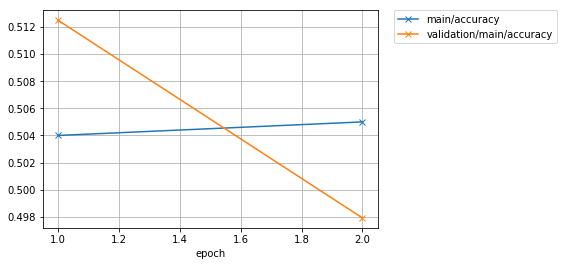

In [24]:
from IPython.display import Image
Image(filename=os.path.join(u'result', u'accuracy.png'))

In [27]:
# ちゃんと保存されていることを確認
%ls -la result/sakamotsu.model

-rw-r--r-- 1 moriyama moriyama 139689426  3月  6 07:44 result/sakamotsu.model


## pyファイルの作成

In [29]:
import subprocess
subprocess.call(['jupyter', 'nbconvert', '--to', 'python', '04_startTrainingSakamotsu_lecture.ipynb'])
%ls -la 04_startTrainingSakamotsu_lecture.py

-rw-r--r-- 1 moriyama moriyama 17202  3月  6 07:45 04_startTrainingSakamotsu_lecture.py
